# 📄 **Project Abstract**
## **Nepali Fake News Detection using Synthetic Dataset & LoRA Fine-Tuning**

This project addresses the challenge of **detecting fake news in Nepali**, a low-resource language with limited labeled datasets.  
To overcome data scarcity, we generated a **synthetic dataset of 8,838 balanced news samples** using **Large Language Models (OpenAI GPT and Google Gemini)**, covering diverse topics such as politics, health, and entertainment available at https://www.kaggle.com/datasets/chhatramaniyadav/nepali-fake-news-detection-dataset/.  

We fine-tuned the **XLM-RoBERTa Large model** using **LoRA (Low-Rank Adaptation)** to achieve high efficiency and performance on standard GPU hardware.  
The resulting model achieved an **F1 score of 99.49%**, demonstrating that synthetic data combined with parameter-efficient fine-tuning is a **viable strategy for building robust NLP classifiers** in low-resource languages.

---

## 👨‍💻 Author

**Chhatramani Yadav**  
Computer Engineering Student, Aspiring AI Engineer & Researcher  
#### 🔗 Connect with Me [LinkedIn](https://www.linkedin.com/in/chhatramani-yadav/)




### **Step 1: Install Required Libraries**
We need the Hugging Face libraries (transformers, peft, datasets) and kagglehub.

In [ ]:
# 1. Install dependencies
!pip install -q kagglehub transformers peft datasets evaluate scikit-learn accelerate torch --upgrade

# 2. Import libraries
import os
import torch
import numpy as np
import pandas as pd
import glob
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Hugging Face Imports
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
import evaluate

# PEFT / LoRA Imports
from peft import LoraConfig, get_peft_model, TaskType, PeftModel

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.0/557.0 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193

### **Step 2: Download and Prepare the Dataset**
This block downloads the dataset from Kaggle, finds the CSV file, cleans the labels, and splits it into training and testing sets.
Dataset: https://www.kaggle.com/datasets/chhatramaniyadav/nepali-fake-news-detection-dataset
This dataset contains 8,838 labeled news samples in the Nepali language, designed specifically for training and evaluating Natural Language Processing (NLP) models for Fake News Detection.

In [ ]:
# 1. Download Dataset from Kaggle
import kagglehub

print("📥 Downloading dataset from Kaggle...")
path = kagglehub.dataset_download("chhatramaniyadav/nepali-fake-news-detection-dataset")
print(f"✅ Dataset downloaded to: {path}")

# 2. Find the CSV file (handling dynamic paths)
csv_files = glob.glob(os.path.join(path, "*.csv"))
if not csv_files:
    raise FileNotFoundError("No CSV file found in the downloaded dataset!")

csv_path = csv_files[0]
print(f"📂 Loading CSV: {os.path.basename(csv_path)}")

# 3. Load Data
df = pd.read_csv(csv_path)

# 4. Preprocessing Labels
# Assuming label column exists. Mapping 'REAL' -> 0, 'FAKE' -> 1
df = df.dropna(subset=['label', 'full_text']) # Ensure we have text and label
label_mapping = {"REAL": 0, "FAKE": 1}
df['label_id'] = df['label'].map(label_mapping)

# Verify mapping
print(f"Label Mapping: {label_mapping}")
print(df['label'].value_counts())

# 5. Train/Test Split (80% Train, 20% Test)
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label_id']
)

print(f"Train size: {len(train_df)} | Test size: {len(test_df)}")

📥 Downloading dataset from Kaggle...


100%|██████████| 1.36M/1.36M [00:00<00:00, 44.2MB/s]

Extracting files...
✅ Dataset downloaded to: /root/.cache/kagglehub/datasets/chhatramaniyadav/nepali-fake-news-detection-dataset/versions/1
📂 Loading CSV: nepali_fake_news_dataset_labelled_v1.csv


Label Mapping: {'REAL': 0, 'FAKE': 1}
label
FAKE    4419
REAL    4419
Name: count, dtype: int64
Train size: 7070 | Test size: 1768


### **Step 3: Initialize Model and Tokenizer**
We use `FacebookAI/xlm-roberta-large`, which is a large, multilingual transformer-based language model developed by Facebook AI (now Meta AI). It is a variant of the RoBERTa model designed specifically for cross-lingual understanding, trained on a massive dataset of 2.5TB of filtered CommonCrawl data covering 100 different languages.

In [ ]:
MODEL_ID = "FacebookAI/xlm-roberta-large" # Use this for native PyTorch support

print(f"🤖 Loading Tokenizer and Model: {MODEL_ID}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
# You do NOT need 'from_tf=True' for this model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    num_labels=2,
    problem_type="single_label_classification"
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"✅ Model loaded on {device}")

🤖 Loading Tokenizer and Model: FacebookAI/xlm-roberta-large


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded on cuda


### **Step 4: Apply LoRA (Low-Rank Adaptation)**
This configures the model to only train a tiny fraction of parameters, making it fast and memory-efficient.

In [ ]:
# 1. Define LoRA Configuration
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,     # Sequence Classification
    r=16,                           # Rank (Higher = more parameters to train, better accuracy)
    lora_alpha=32,                  # Alpha scaling (Usually 2x r)
    lora_dropout=0.1,               # Dropout
    bias="none",                    # Don't train bias
    target_modules=["query", "value"] # Target attention layers (Standard for BERT)
)

# 2. Wrap the model with PEFT
print("🔧 Applying LoRA Adapters...")
model = get_peft_model(model, peft_config)

# Print trainable parameters statistics
model.print_trainable_parameters()
# You should see trainable parameters < 1% of total parameters

🔧 Applying LoRA Adapters...
trainable params: 2,624,514 || all params: 562,516,996 || trainable%: 0.4666


### **Step 5: Tokenize Dataset**
We convert the pandas DataFrames into Hugging Face Datasets and tokenize the text.

In [ ]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["full_text"],
        truncation=True,
        max_length=512  # Max length for BERT models
    )

# Convert pandas to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Apply Tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Remove unnecessary columns, keeping only 'label' and input features
train_dataset = train_dataset.remove_columns(['label', 'headline', 'body', 'full_text', '__index_level_0__'])
test_dataset = test_dataset.remove_columns(['label', 'headline', 'body', 'full_text', '__index_level_0__'])

# Rename 'label_id' to 'labels' (Trainer expects this column name)
train_dataset = train_dataset.rename_column("label_id", "labels")
test_dataset = test_dataset.rename_column("label_id", "labels")

# Set format for PyTorch
train_dataset.set_format("torch")
test_dataset.set_format("torch")

Map:   0%|          | 0/7070 [00:00<?, ? examples/s]

Map:   0%|          | 0/1768 [00:00<?, ? examples/s]

### **Step 6: Define Metrics and Training Arguments**
We configure the training loop for the T4 GPU using FP16 (Mixed Precision) for speed.

In [ ]:
# 1. Define Metrics (Accuracy and F1)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='binary') # Binary F1

    return {
        "accuracy": accuracy,
        "f1_score": f1
    }

# 2. Training Arguments
training_args = TrainingArguments(
    output_dir="xlm_roberta_large_lora",
    eval_strategy="epoch",     # Evaluate every epoch
    save_strategy="epoch",           # Save every epoch
    learning_rate=2e-5,              # Standard learning rate for BERT
    per_device_train_batch_size=8,   # Safe batch size for T4 with length 512
    per_device_eval_batch_size=8,
    num_train_epochs=3,              # 3 Epochs is usually enough for fine-tuning
    weight_decay=0.01,
    logging_steps=50,
    fp16=True,                       # Use Mixed Precision (Speeds up T4 training)
    load_best_model_at_end=True,
    metric_for_best_model="f1_score",
    save_total_limit=1,              # Only keep the best model
    report_to="none"                 # Disable wandb/mlflow logging
)

##### optional

In [ ]:
# NO NEED TO RUN THIS
# # 1. Define Metrics (Accuracy and F1)
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)

#     accuracy = accuracy_score(labels, predictions)
#     f1 = f1_score(labels, predictions, average='binary')

#     return {
#         "accuracy": accuracy,
#         "f1_score": f1
#     }

# # 2. Training Arguments (OPTIMIZED FOR xlm-roberta-large on T4 GPU)
# training_args = TrainingArguments(
#     output_dir="./xlm_roberta_large_lora",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=2e-5,

#     # --- MEMORY OPTIMIZATION STARTS HERE ---
#     # Reduced batch size from 8 to 4 to fit the large model on T4 GPU
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,

#     # Accumulate gradients for 2 steps.
#     # This simulates a batch size of 8 (4 * 2) without the extra memory usage.
#     gradient_accumulation_steps=2,
#     # --- MEMORY OPTIMIZATION ENDS HERE ---

#     num_train_epochs=3,
#     weight_decay=0.01,
#     logging_steps=50,
#     fp16=True,               # Essential for speed on T4
#     load_best_model_at_end=True,
#     metric_for_best_model="f1_score",
#     save_total_limit=1,
#     report_to="none"
# )

# print("✅ Training Arguments configured for xlm-roberta-large")

### **Step 7: Initialize Trainer and Start Training**
Now we put everything together and start the fine-tuning process.

In [ ]:
# Data Collator (Dynamic Padding)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Start Training
print("🚀 Starting Fine-Tuning...")
trainer.train()

🚀 Starting Fine-Tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.071400,0.042472,0.984729,0.984615
2,0.087300,0.035462,0.993778,0.993754
3,0.046400,0.025087,0.994910,0.994901


TrainOutput(global_step=2652, training_loss=0.11452473270018788, metrics={'train_runtime': 435.5771, 'train_samples_per_second': 48.694, 'train_steps_per_second': 6.088, 'total_flos': 4496240367688896.0, 'train_loss': 0.11452473270018788, 'epoch': 3.0})

### **Step 8: Final Evaluation and Inference Test**
After training, we run a final evaluation on the test set and test a few sentences manually.

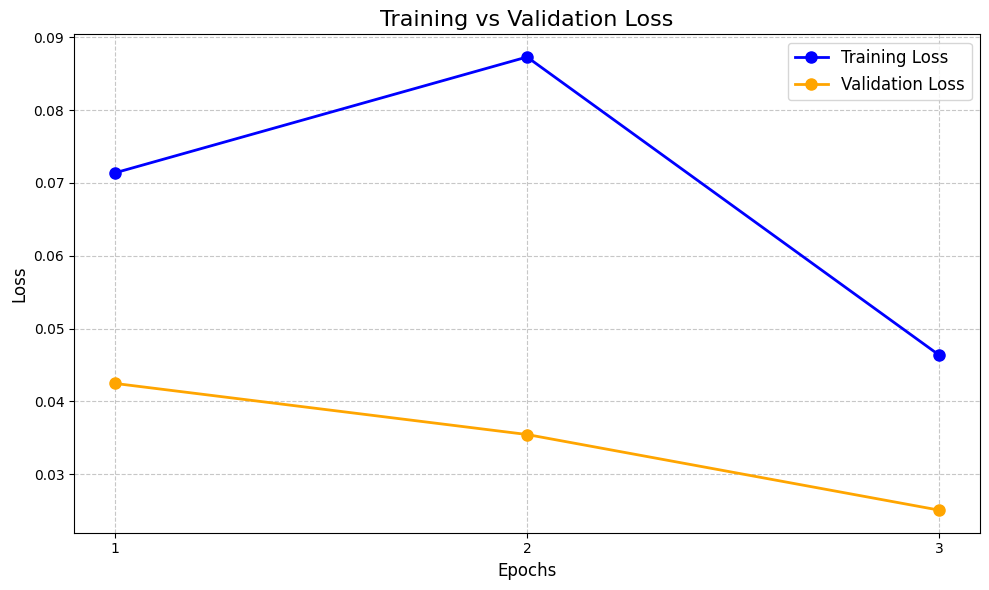

In [ ]:
import matplotlib.pyplot as plt

# 1. Data extracted from your output log
epochs = [1, 2, 3]
training_loss = [0.071400, 0.087300, 0.046400]
validation_loss = [0.042472, 0.035462, 0.025087]

# 2. Create the plot
plt.figure(figsize=(10, 6))

# Plotting Training Loss
plt.plot(epochs, training_loss, label='Training Loss', marker='o', color='blue', linewidth=2, markersize=8)

# Plotting Validation Loss
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o', color='orange', linewidth=2, markersize=8)

# 3. Adding labels and title
plt.title('Training vs Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# 4. Adding grid and legend for better readability
plt.xticks([1, 2, 3]) # Ensure X-axis only shows the 3 epochs
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# 5. Display the graph
plt.tight_layout()
plt.show()

**Inferenence & Testing**

In [ ]:
# 1. Final Evaluation on Test Set
print("\n" + "="*30)
print("📊 FINAL EVALUATION RESULTS")
print("="*30)
eval_results = trainer.evaluate()
print(eval_results)

# 2. Manual Inference Test Function
def predict_news(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()

    label = "REAL" if prediction == 0 else "FAKE"
    confidence = torch.softmax(logits, dim=-1).max().item()
    return label, confidence

# 3. Test Examples
print("\n" + "="*30)
print("🧪 TESTING ON EXAMPLES")
print("="*30)

# Example 1 To test
#sample = "कांग्रेस केन्द्रीय कार्यसमिति बैठकको निर्णय : निष्क्रिय रहेका र छाडेकालाई पुन: पार्टीमा जोडिन आह्वान" <-- Put your news text here
sample = "विद्यमान राजनीतिक समस्या समाधान गर्न निर्वाचनको विकल्प छैन : संयोजक दाहाल"  # <-- Put your news text here
label, conf = predict_news(sample)
print(f"Text: {sample}")
print(f"Prediction: {label} (Confidence: {conf:.4f})")

print("-" * 30)



📊 FINAL EVALUATION RESULTS


{'eval_loss': 0.025086836889386177, 'eval_accuracy': 0.9949095022624435, 'eval_f1_score': 0.9949008498583569, 'eval_runtime': 18.4694, 'eval_samples_per_second': 95.726, 'eval_steps_per_second': 11.966, 'epoch': 3.0}

🧪 TESTING ON EXAMPLES
Text: विद्यमान राजनीतिक समस्या समाधान गर्न निर्वाचनको विकल्प छैन : संयोजक दाहाल
Prediction: REAL (Confidence: 0.9999)
------------------------------


In [ ]:
# ==========================================
# 1. Final Evaluation on Full Test Set
# ==========================================
print("\n" + "="*30)
print("📊 FINAL EVALUATION RESULTS (Full Test Set)")
print("="*30)
eval_results = trainer.evaluate()
print(eval_results)

# ==========================================
# 2. Manual Inference Test Function
# ==========================================
def predict_news(text):
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
    inputs = inputs.to(device)

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()

    # Process Result
    label = "REAL" if prediction == 0 else "FAKE"
    confidence = torch.softmax(logits, dim=-1).max().item()
    return label, confidence

# ==========================================
# 3. Test on Specific Number of Examples from Test Dataset
# ==========================================
# 🔵 CHANGE THIS NUMBER to test more or fewer examples (e.g., 5, 10, 20)
num_examples_to_test = 10

print("\n" + "="*30)
print(f"🧪 TESTING ON {num_examples_to_test} EXAMPLES FROM TEST DATASET")
print("="*30)

for i in range(num_examples_to_test):
    # Get the i-th item from the test_dataset
    # test_dataset is already tokenized and ready
    item = test_dataset[i]

    # Get the true label ID (0 for REAL, 1 for FAKE)
    true_label_id = item['labels'].item()

    # Decode the input_ids back to readable text
    # We skip special tokens (<s>, </s>, <pad>)
    text = tokenizer.decode(item['input_ids'], skip_special_tokens=True)

    # Run prediction
    pred_label, conf = predict_news(text)

    # Convert true ID to string for comparison
    true_label_str = "REAL" if true_label_id == 0 else "FAKE"

    # Check if prediction was correct
    status_icon = "✅" if pred_label == true_label_str else "❌"

    # Print result
    # Limit text display to 150 characters for cleaner output
    display_text = (text[:150] + '...') if len(text) > 150 else text

    print(f"Sample {i+1}:")
    print(f"Text: {display_text}")
    print(f"True: {true_label_str} | Pred: {pred_label} (Conf: {conf:.4f})")
    print(f"Result: {status_icon}")
    print("-" * 30)

print("\n✅ Evaluation Complete!")
print(f"💾 Model saved in ./xlm_roberta_large_lora")


📊 FINAL EVALUATION RESULTS (Full Test Set)


{'eval_loss': 0.025086836889386177, 'eval_accuracy': 0.9949095022624435, 'eval_f1_score': 0.9949008498583569, 'eval_runtime': 13.8402, 'eval_samples_per_second': 127.744, 'eval_steps_per_second': 15.968, 'epoch': 3.0}

🧪 TESTING ON 10 EXAMPLES FROM TEST DATASET
Sample 1:
Text: फिफाले नेपाललाई सधैँका लागि निलम्बन गर्यो अन्तर्राष्ट्रिय समाचार!!! नेपाल सरकारको हस्तक्षेपका कारण फिफाले नेपाललाई फुटबलबाट सधैँका लागि प्रतिबन्ध लगाए...
True: FAKE | Pred: FAKE (Conf: 1.0000)
Result: ✅
------------------------------
Sample 2:
Text: काठमाडौँ उपत्यकाका लागि स्मार्ट सिटी गुरुयोजना सार्वजनिक सहरी विकास मन्त्रालयले उपत्यकाका चारवटा क्षेत्रमा आधुनिक सुविधायुक्त स्मार्ट सिटी निर्माणको व...
True: REAL | Pred: REAL (Conf: 0.9999)
Result: ✅
------------------------------
Sample 3:
Text: बुद्ध नेपालमा जन्मेका हैनन्, सरकारले ढाँटेको प्रमाण भेटियो !!! भारतले नयाँ प्रमाण निकाल्यो, बुद्ध भारतमै जन्मेका हुन्, अब नेपालले माफी माग्नुपर्ने !!!
True: FAKE | Pred: FAKE (Conf: 1.0000)
Result: ✅
----------------------

### **Save the model**

In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Copy the trained model folder to your Drive
shutil.copytree("./xlm_roberta_large_lora", "/content/drive/MyDrive/nepali_fake_news_model")

print("✅ Model saved to your Google Drive under 'nepali_fake_news_model'")

## 📌 **Conclusion**

The training run was highly successful, with strong metrics and healthy learning behavior.

### 🔍 Metrics
- **Final Accuracy:** 99.49% 🏆  
- **Final F1 Score:** 0.9949 🏆  
- **Validation Loss:** 0.025 📉  
- **Training Loss:** 0.046 📉  

### ✅ Why Good?
- **No Overfitting:** Both training and validation loss decreased across epochs.  
- **High F1 Score:** Balanced precision and recall, crucial for fake news detection.  

### ⚠️ Real-World Gap
Performance is excellent on synthetic data, but real-world accuracy may drop (≈85–90%) due to slang, dialects, and noise not present in the dataset. Continuous monitoring is recommended.


## 📝 Citation
```bibtex
@dataset{nepali_fake_news_dataset_2026,
  title     = {Nepali Fake News Detection Dataset},
  author    = {Chhatramani Yadav},
  year      = {2026},
  publisher = {Kaggle},
  url       = {https://www.kaggle.com/datasets/chhatramaniyadav/nepali-fake-news-detection-dataset}
}
```